# Wildfire Analysis

First things first: Imports.

In [0]:
# In order to be able to read parquet files
!pip install pyarrow
import pandas as pd

## Load the wildfire training data

Let's read in the training data from its home in my AFS www directory. This can take a bit of time (30s to a minute or so).

In [0]:
df = pd.read_parquet('http://web.stanford.edu/~sjespers/cs221/train-wildfires.parquet')

# To load a smaller, more manageable sample of the training set, run this instead:
# df = pd.read_parquet('http://web.stanford.edu/~sjespers/cs221/wildfires-sample.parquet')

## Data cleaning/preparation

Here we prep the dataframe for input into keras/sklearn. First, we lowercase all column names, and we might as well drop the columns we don't care about.

In [0]:
INTERESTING_COLS = """
fire_size
fire_year
discovery_date
discovery_time
stat_cause_code
stat_cause_descr
cont_date
cont_doy
cont_time
latitude
longitude
state
county
fips_code
nwcg_reporting_unit_id
""".strip().split("\n")

df.rename(columns={s: s.lower() for s in df.columns}, inplace=True)
df.stat_cause_code = df.stat_cause_code.astype(int)
df = df.filter(items=INTERESTING_COLS)

Now we drop codes 9 and 13, corresponding to miscellaneous and unknown causes, which are pretty useless.

In [0]:
df = df[(df.stat_cause_code != 9) & (df.stat_cause_code != 13)]

At this point, it's interesting to see the distribution of the remaining causes. Note that debris burning is the clear front-runner:

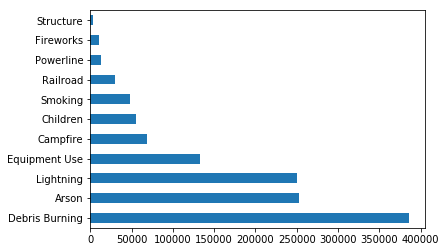

In [0]:
df.stat_cause_descr.value_counts().plot(kind='barh')

Now, we need to one-hot encode the categorical labels:

In [0]:
label_df = pd.get_dummies(df.stat_cause_descr)
labels = label_df.values

Let's handle the features next. First, we define a new feature, `burn_time`, in terms of two others, taking note of where it's not available:

In [0]:
df['burn_time'] = df.cont_date - df.discovery_date
df['burn_time_notna'] = df.burn_time.notna().astype(int)

Then, filtering to just the ones we care about:

In [0]:
FEATURE_COLS = """
fire_size
fire_year
burn_time
burn_time_notna
latitude
longitude
""".strip().split("\n")

data = df.filter(items=FEATURE_COLS)

### Feature scaling

MLP's are apparently rather sensitive to feature scaling, so we should normalize all features to within a similar range, e.g. (0, 1) or (-1, 1).

In order to do this, we first check the ranges of the various columns:

In [0]:
data.describe()

,fire_size,fire_year,burn_time,burn_time_notna,latitude,longitude
count,1.251271e+06,1.251271e+06,679291.000000,1.251271e+06,1.251271e+06,1.251271e+06
mean,8.425213e+01,2.003325e+03,1.275430,5.428808e-01,3.701755e+01,-9.581148e+01
std,2.760037e+03,6.638181e+00,15.054777,4.981580e-01,5.840018e+00,1.571389e+01
min,9.000000e-05,1.992000e+03,0.000000,0.000000e+00,1.794492e+01,-1.733857e+02
25%,1.000000e-01,1.998000e+03,0.000000,0.000000e+00,3.281042e+01,-1.098029e+02
50%,1.000000e+00,2.003000e+03,0.000000,1.000000e+00,3.543330e+01,-9.146357e+01
75%,4.000000e+00,2.009000e+03,0.000000,1.000000e+00,4.085033e+01,-8.273000e+01
max,6.069450e+05,2.015000e+03,4018.000000,1.000000e+00,7.033060e+01,-6.525694e+01


Then we can normalize and fill in the gaps:

In [0]:
def normalize(df):
  newdf = df.copy()
  # fire_year is between 1992 and 2015
  newdf.fire_year = (df.fire_year - 1992) / (2015 - 1992)
  # fire_size is between 0 and ~100,000 (acres)
  newdf.fire_size = 1. * df.fire_size / 100000
  # burn_time is between 0 and ~5,000
  newdf.burn_time = 1. * df.burn_time / 5000
  # shove -1 into burn_time where we don't have it;
  # the NN should pick up on this
  newdf.burn_time.fillna(-1, inplace=True)
  # latitude: take (-90, 90) -> (-1, 1)
  newdf.latitude /= 90
  # longitude: take (-180, 180) -> (-1, 1)
  newdf.longitude /= 180
  return newdf

In [0]:
normalized_data = normalize(data)

Let's take a look at the data just to make sure things are going basically as we would expect at this point:

In [0]:
normalized_data.sample(10)

,fire_size,fire_year,burn_time,burn_time_notna,latitude,longitude
OBJECTID,,,,,,
840194,0.000005,0.260870,-1.0,0,0.387731,-0.481498
1039717,0.000001,0.391304,-1.0,0,0.386297,-0.429537
876380,0.000005,0.304348,-1.0,0,0.368651,-0.467883
1536634,0.000003,0.739130,-1.0,0,0.367602,-0.540724
1290722,0.000001,0.739130,0.0,1,0.475315,-0.410770
149383,0.000001,0.434783,0.0,1,0.434830,-0.669907
133393,0.000010,0.347826,0.0,1,0.351593,-0.616213
1031051,0.000010,0.304348,-1.0,0,0.404352,-0.427379
265108,0.000001,0.608696,0.0,1,0.480349,-0.569292


## Keras MLP

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics

Okay, let's set up a simple MLP for multiclass softmax classification:

In [0]:
model = Sequential([
    Dense(128, activation='relu', input_dim=len(data.columns)),
    Dense(128, activation='relu'),
    Dense(labels.shape[1], activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Time to fit the model:

In [0]:
history = model.fit(normalized_data.values, labels, epochs=5, batch_size=256, validation_split=0.222)

Train on 973488 samples, validate on 277783 samples
Epoch 1/5
973488/973488 [==============================] - 18s 18us/step - loss: 1.4293 - acc: 0.5108 - val_loss: 1.4307 - val_acc: 0.5078
Epoch 2/5
973488/973488 [==============================] - 18s 18us/step - loss: 1.4271 - acc: 0.5112 - val_loss: 1.4257 - val_acc: 0.5105
Epoch 3/5
973488/973488 [==============================] - 18s 18us/step - loss: 1.4252 - acc: 0.5120 - val_loss: 1.4308 - val_acc: 0.5102
Epoch 4/5
973488/973488 [==============================] - 19s 19us/step - loss: 1.4228 - acc: 0.5127 - val_loss: 1.4242 - val_acc: 0.5112
Epoch 5/5
973488/973488 [==============================] - 18s 18us/step - loss: 1.4212 - acc: 0.5133 - val_loss: 1.4197 - val_acc: 0.5111


We'll define a helper function for computing balanced accuracy now:

In [0]:
import sklearn

def balanced_accuracy(ytrue, ypred):
  return sklearn.metrics.balanced_accuracy_score(
      np.argmax(ytrue, axis=1),
      np.argmax(ypred, axis=1))

In [0]:
mlp_ypred = model.predict(normalized_data.values)

In [0]:
balanced_accuracy(labels, mlp_ypred)

0.2512732529752906

### Save the model

I'd suggest downloading this locally, too, just to make sure that if this notebook dies on you, you still have your progress saved.

In [0]:
model.save('cs221-finalproj-initialmodel.h5')

### Confusion Matrix

It'd be nice to get a feel for how well the model is doing on each of the 11 categories. First, we need the predicted values:

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [0]:
ypred = model.predict(normalized_data.values)

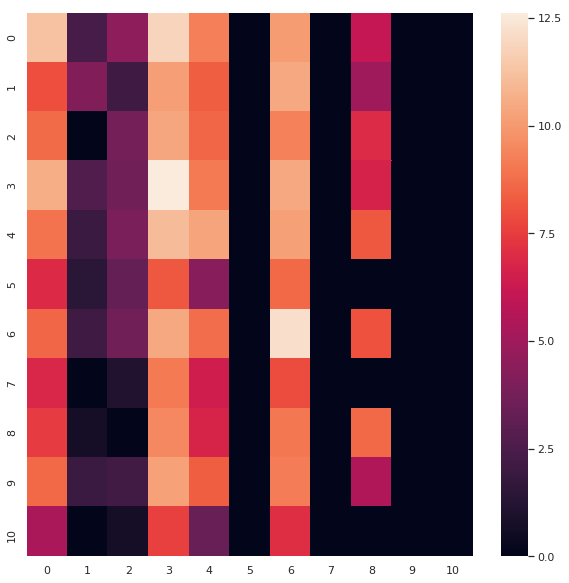

In [0]:
confusion_mtx = sklearn.metrics.confusion_matrix(
    np.argmax(labels, axis=1),
    np.argmax(ypred, axis=1))

sns.set()
plt.figure(figsize=(10, 10))
sns.heatmap(np.log(confusion_mtx + 1))#, annot=True, fmt=".2f")

## Sklearn *k*-NN Oracle

Here we run *k*-NN for the training data, for use as an oracle, a target for our MLP to shoot for.

In [0]:
from sklearn.neighbors import KNeighborsClassifier

### *k* = 10

*k* = 10 should give okay but not great results.

In [0]:
knn = KNeighborsClassifier(n_neighbors=10)

In [0]:
knn.fit(data, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [0]:
y_pred = knn.predict(data)

Let's take a peek at the balanced accuracy for `k=10`:

In [0]:
balanced_accuracy(labels, y_pred)

0.30348264481573406

### *k* = 5

*k* = 5 should be a little better.

In [0]:
knn2 = KNeighborsClassifier(n_neighbors=5)

In [0]:
knn2.fit(data, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
ypred2 = knn2.predict(data)

In [0]:
balanced_accuracy(labels, ypred2)

0.40252320082885223

### *k* = 3

Now we're starting to approach *k* = 1, which is by definition 100% accurate, so we expect to continue to see the accuracy rise.

In [0]:
knn3 = KNeighborsClassifier(n_neighbors=3)

In [0]:
knn3.fit(data, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
y_pred3 = knn3.predict(data)

In [0]:
balanced_accuracy(labels, y_pred3)

0.5000034153736788

## Sklearn logistic regression

In [0]:
from sklearn.linear_model import LogisticRegressionCV

In [0]:
logistic_model = LogisticRegressionCV(cv=5, solver='lbfgs', multi_class='multinomial')

In [0]:
data_no_na = data.dropna()
no_na_labels = df.stat_cause_code[data_no_na.index]

In contrast to Keras, which likes the multiclass output labels to be expressed as vectors (with as many entries as categories), sklearn expects scalar labels, hence the invocation of `np.argmax`. Let's fit the model:

In [0]:
logistic_model.fit(data_no_na, no_na_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


KeyboardInterrupt: ignored